# s1 Variable

This is a gan trying to recreate the 1D distribution of the s1 variable. The S1 variable is the initial scintillation.

Import relevant libraries & use uproot to open it.

In [1]:
import uproot
import pandas
import matplotlib.pyplot as plt
import numpy as np

tree = uproot.open("ROOT/outRunNeutron2.root")["dstree"]

## Understand the data

The different variables contained within the tree. This is usually done at the start of every Jupyter notebook to allow me to make sure I have the variables and the types of the variables available. Generally this is good habit and is something I would recommend. 

If you have problems with a variable, I would strongly recommend opening the file in a TBrowser in root.

Some variables are given as lists of lists, and therefore need to be 'unpacked'.

In [2]:
tree.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
r                          (no str

## Understand the distribution

After extracting the variables required, they may need more refining, however in this example, it is not the case. The x variable has been extracted and stored in train_DS. It is then plotted to ensure we have an understanding of the distribution.

Training Dataset is the s1 variable. It has been divided by 8000 to give it a nicer range of between 0 and 1, to make it easier for the GAN to learn. 

In [3]:
train_DS = tree.array("s1ene") / 8000

(array([8.51809572e+00, 2.14669751e-02, 1.54562241e-02, 1.20215045e-02,
        9.44547025e-03, 8.58679114e-03, 8.58679114e-04, 0.00000000e+00,
        0.00000000e+00, 8.58679114e-04]),
 array([0.        , 0.11645795, 0.23291591, 0.34937385, 0.46583182,
        0.58228976, 0.6987477 , 0.81520563, 0.93166363, 1.0481216 ,
        1.1645795 ], dtype=float32),
 <a list of 10 Patch objects>)

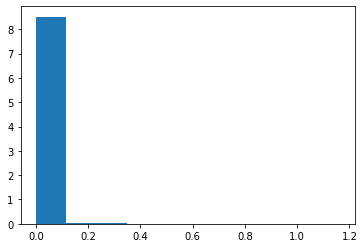

In [4]:
plt.hist(train_DS, density = True)

We then set the number of training examples and the size of the noise. In this case, I set the noise size to 1000, thinking it had to be the same as the training data. However this is not the case, as the generator will transform the noise data into the appropriate number of points. 

Something that may be interesting to explore later is the effect of **varying the size of the noise** 

In [5]:
num_train = len(train_DS)
noise_size = 10000

In [6]:
#  Model dependent constants
#  Define model PDF

#The range of the model
range_min, range_max = 0, 1
#The range being plot
range_width = range_max - range_min

plot_resolution = 50

## Creation of the GAN

After setting some variables, the GAN is created. Generally there is no 'official documentation' on the correct setup of either the generator or disciminator. However the output of the disciminator should be a softmax, so it outputs a probability of the point being real/fake.

Binary Crossentropy is used to compare a probability (probaility image is real) with a 0,1 which is if it is real or fake. 

The generator is trying to maximise this, and make the disciminator bad at telling the difference, whilst the disciminator is trying to minimise this. 

A simple overview is found on this website: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

In [7]:
#  Create GAN

from tensorflow.keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.models     import Model, Sequential
from tensorflow.keras.optimizers import Adam

#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(50, activation="relu", input_shape=(1,)))
d.add(Dense(50, activation="relu"))
d.add(LeakyReLU(0.2))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(50, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(50, activation="relu"))
g.add(BatchNormalization())
g.add(Dense(1, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
gan.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 2,752
Trainable params: 2,752
Non-trainable params: 0
_________________________________________________________________
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                500050    
________________________________

In [8]:
#  Func: plot GAN progress

def plot_points_GAN (data, label, epoch, batch_size, d_acc, gan_acc) :
    
    #y = plt.hist(train_DS , alpha = 0.3,density = True, label = 'Real Data')
    #x = np.linspace(range_min, range_max, 200)
    h = plt.hist(data, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue", alpha=0.6,density = True, label=label)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("x", size=14, labelpad=10)
    #y_max = 1.5*max([max(y),max(h[0])])
    y_max = 8
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])

    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    plt.savefig("Train_epoch{epoch}.png", dpi=96)
    plt.show()

### Epochs and Batch Size

**Epochs** are the number of times the generator and discrimiator are 'reweighted'. 
The **batch size** is the number of the training data randomly extracted to run through the GAN. The bigger this is, the better it is for the GAN, but the longer it will take.

In [9]:
#  Train GAN
epochs     = 5000
batch_size = 1000

## Running the GAN

The code below runs the GAN, initially I attemped to make the noise as close to the real data as possible, but this is pointless, as it goes through the GAN anyway. 

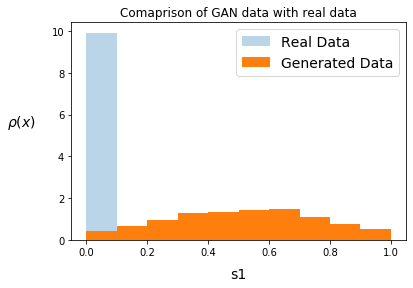

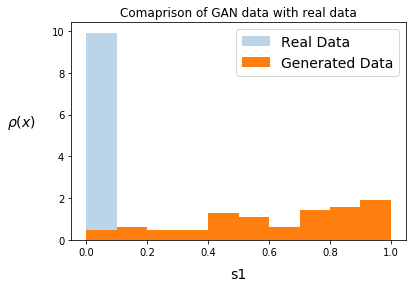

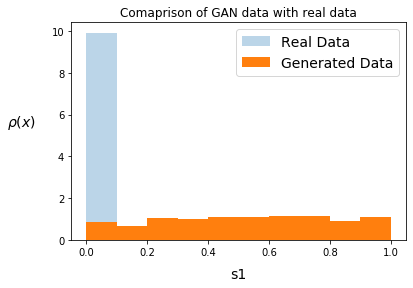

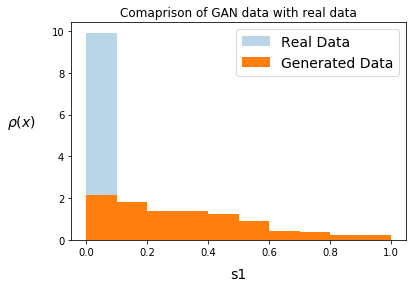

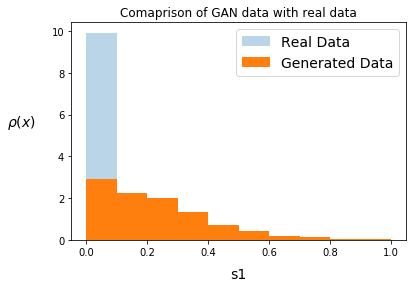

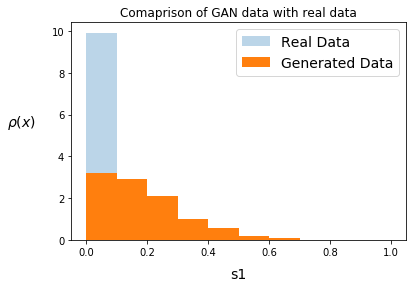

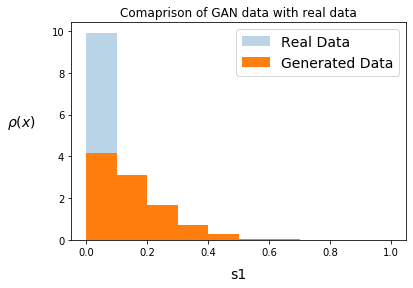

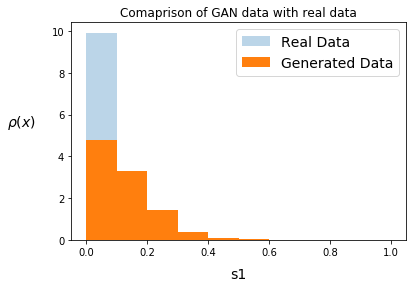

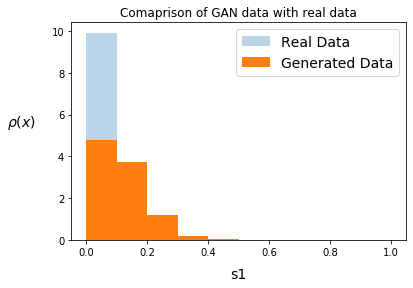

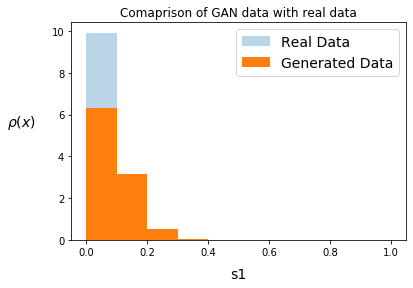

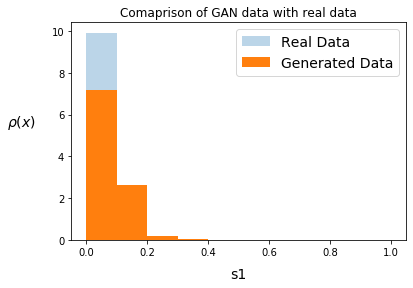

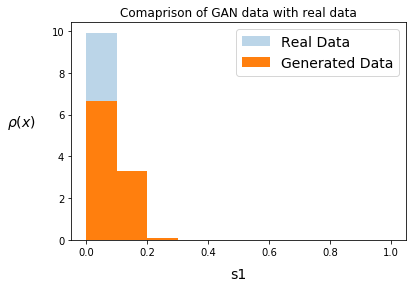

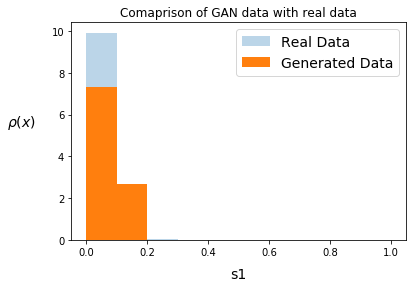

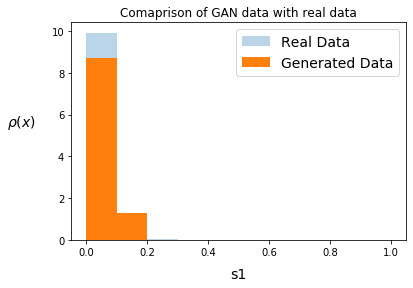

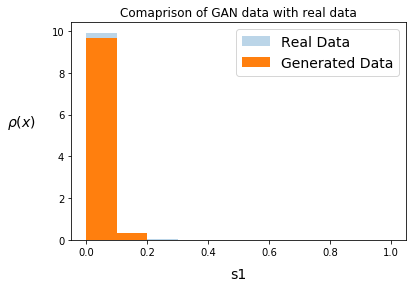

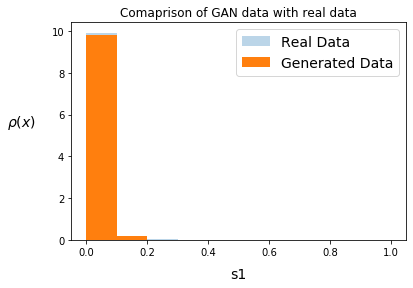

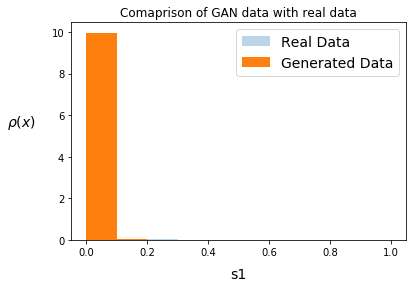

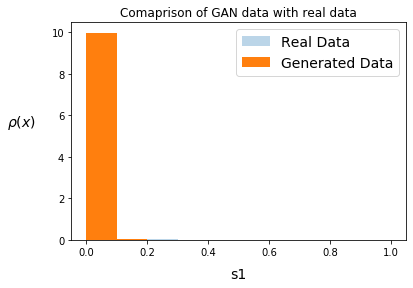

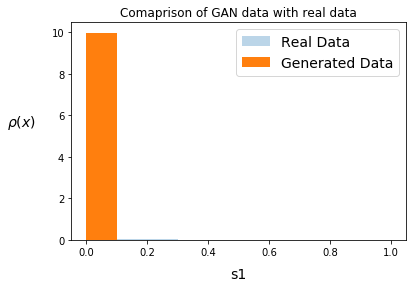

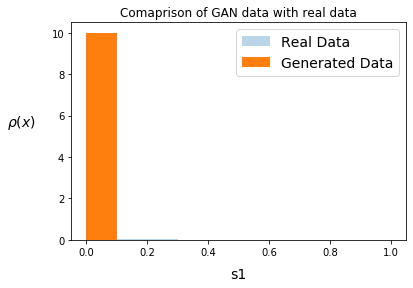

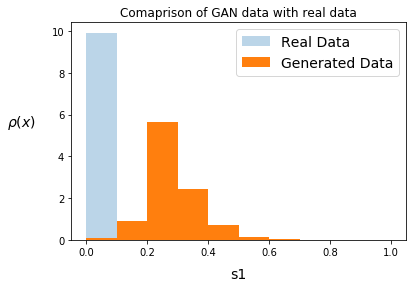

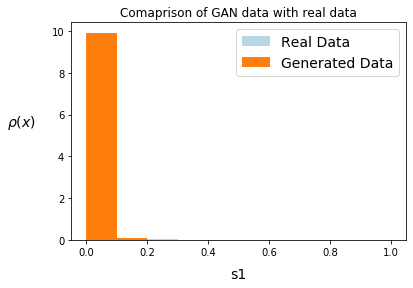

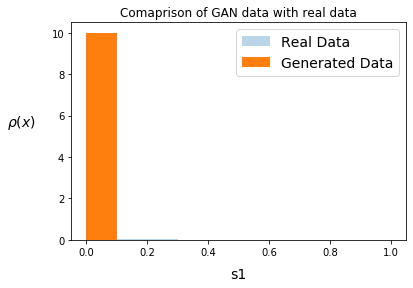

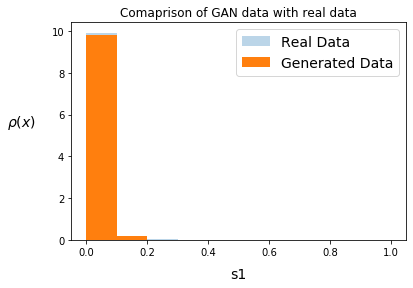

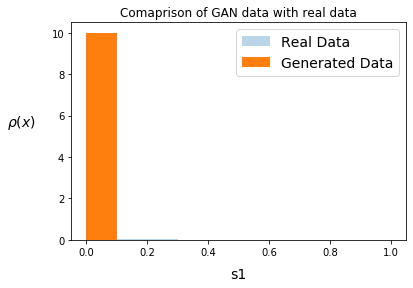

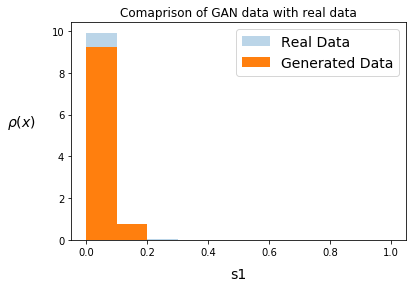

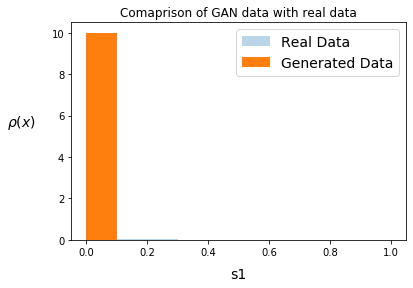

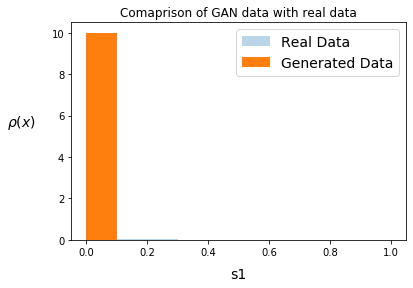

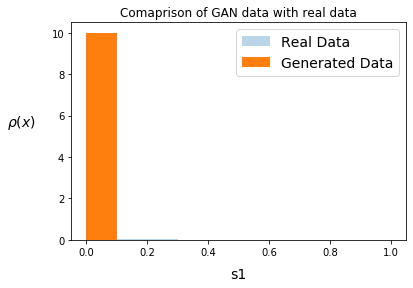

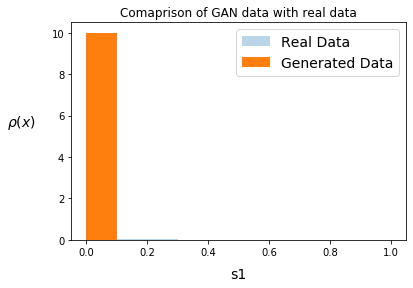

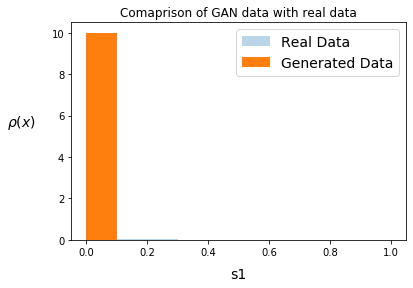

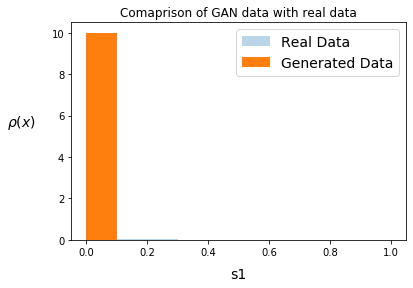

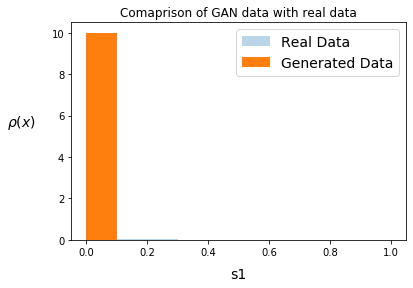

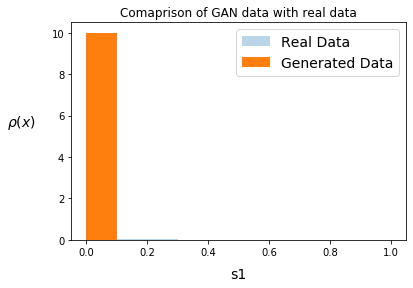

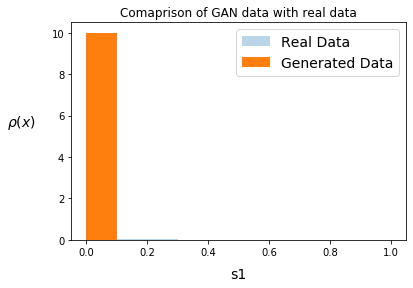

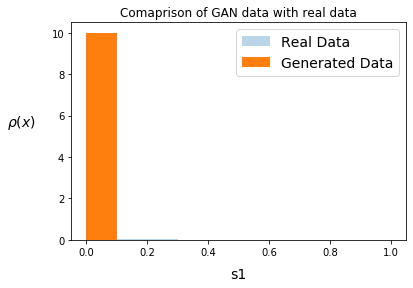

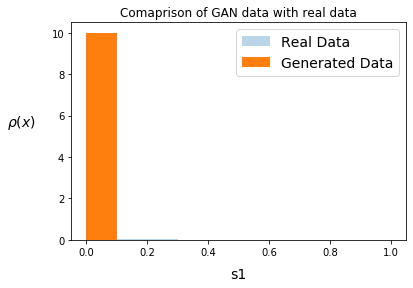

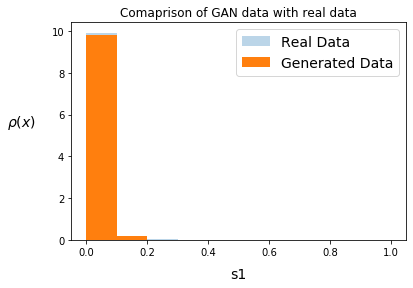

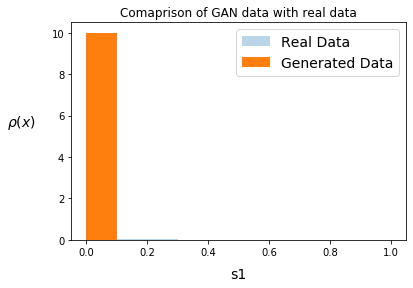

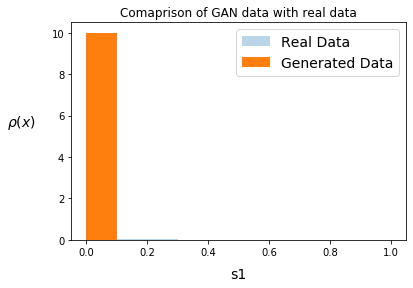

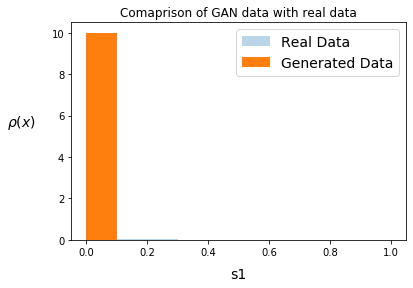

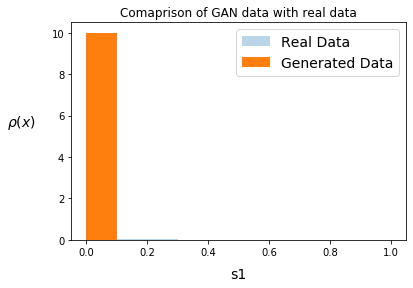

In [ ]:
epochs_saved = []
loss = []
epoch_no = []
for e in range(epochs) :
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    
    #Get the real and fake data
    batch_DS = train_DS[np.random.randint(0, len(train_DS), batch_size)].reshape(batch_size, 1)
    #fake data made from predicting noise
    #print(batch_DS)
    gen_DS   = g.predict(noise)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)

        
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
        gen_DS = g.predict(noise)
        epoch_no.append(e)
        y1 = plt.hist(train_DS, alpha = 0.3,density = True,range = (0,1), bins = 10, label = 'Real Data')
        y2 = plt.hist(gen_DS, density = True,range = (0,1), bins = 10, label = 'Generated Data')
        plt.legend(loc="upper right", fontsize=14)
        plt.xlabel("s1", size=14, labelpad=10)
        plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
        plt.title("Comaprison of GAN data with real data")
        plt.savefig("Train_epoch_s1.png", dpi=96)
        plt.show()
        loss.append(d_acc)
        epochs_saved.append(e+1)


## Plotting Discriminator Accuracy

As the generator gets better at fooling the disciminator, the accuracy of the disciminator should decrease, as it finds it harder to tell the difference.

In [ ]:
plt.plot(epoch_no,loss)
plt.xlabel("Number of Epochs Elapsed")
plt.ylabel("Accuracy")
plt.title("Accuracy of Disciminator")